# DataSet class walkthrough

In this notebook we are going to go through the mighty `DataSet` class, and get an overview of the most of it's methods and properties. In this case, the more you know, the more you can achieve.

## Note on DataSet object creation

Users are expected to obtain `DataSet` objects in the following ways:

* run a `Measurement` and get a `DataSet` via a `DataSaver` after exiting the measurement context, as shown here:

```python
...
meas = Measurement(...)
...
with meas.run() as datasaver:
    ...
dataset = datasaver.dataset  # <- this one
...
```

* load a `DataSet` using one of the `load_*` functions from `qcodes.dataset.data_set` module, for example, `load_by_run_spec`:

```python
dataset = load_by_run_spec(
    experiment_name='pinchoff',
    sample_name='SDH-X-13c',
    captured_run_id=12
)
```

Users should **NOT** instantiate a `DataSet` object via its constructor, or via the `new_data_set` function.

## Preparation: a DataSet from a dummy Measurement

In order to obtain a `DataSet` object, we are going to run a `Measurement` storing some dummy data (see notebook on [Performing measurements using qcodes parameters and dataset](Performing-measurements-using-qcodes-parameters-and-dataset.ipynb) for more details).

In [1]:
import os
import tempfile
import time

import numpy as np

from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.parameters import Parameter
from qcodes.station import Station

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/240704-9904-qcodes.log


In [2]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='greco',
    sample_name='draco')

In [3]:
# This parameter is created in order to
# justify creation of a `Station` object,
# which, in turn, is needed to remind the
# reader about the importance of adding
# all instruments to the station.
fs = Parameter(name='force_side', label='Side of the Force',
               initial_value='dark',
               set_cmd=None, get_cmd=None)

In [4]:
station = Station()
station.add_component(fs)

'force_side'

In [5]:
x = Parameter(name='x', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
t = Parameter(name='t', label='Time', unit='s',
              set_cmd=None, get_cmd=None)
y = Parameter(name='y', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
y2 = Parameter(name='y2', label='Current', unit='A',
               set_cmd=None, get_cmd=None)

In [6]:
meas = Measurement(exp=experiment,
                   name='first_run',
                   station=station)

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(y, setpoints=(x, t))
meas.register_parameter(y2, setpoints=(x, t))

x_vals = np.linspace(-4, 5, 50)
t_vals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in x_vals:
        for tv in t_vals:
            yv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            y2v = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv + 0.5*np.pi) - 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (y, yv), (y2, y2v))
    time.sleep(1.0)

dataset = datasaver.dataset

Starting experimental run with id: 1. 


For the sake of demonstrating what kind of data we've produced, let's use `plot_dataset` to make some default plots of the data.

([<Axes: title={'center': 'Run #1, Experiment greco (draco)'}, xlabel='Voltage (V)', ylabel='Time (ks)'>,
  <Axes: title={'center': 'Run #1, Experiment greco (draco)'}, xlabel='Voltage (V)', ylabel='Time (ks)'>],
  <matplotlib.colorbar.Colorbar at 0x7f9d435077d0>])

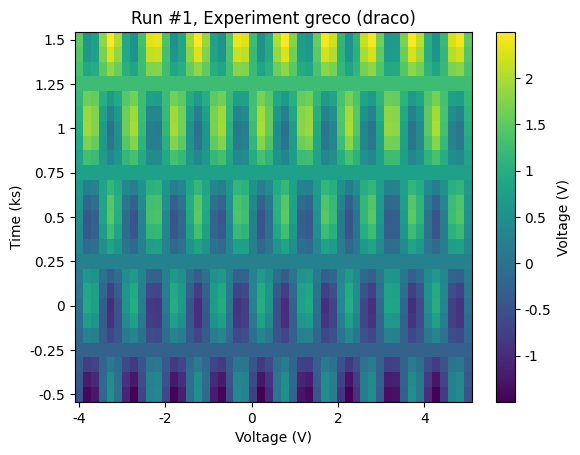

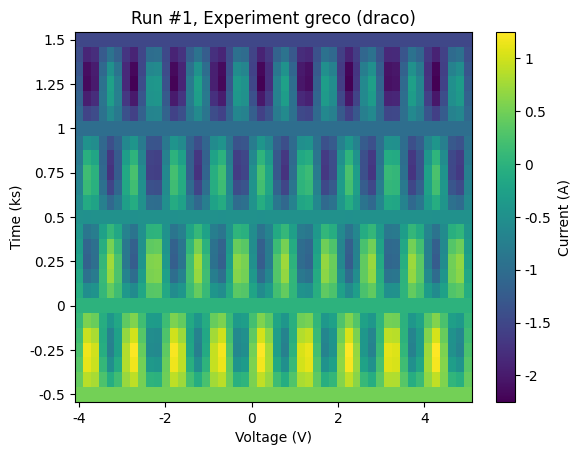

In [7]:
plot_dataset(dataset)

## Note on immutability of DataSet

Users are NOT expected to use `DataSet`s methods that modify its content, for example, `add_result`. Only `Measurement` and `DataSaver` objects use those methods. This is due to the philosophy of the `DataSet` - once created within a `Measurement` context, it should not change so that the user don't accidentally modify/remove the important measured data. In the future versions of QCoDeS the design of the `DataSet` object will be improved to make the described philosophy clear.

## DataSet indentity

Before we dive into what's in the `DataSet`, let's briefly note how a `DataSet` is identified.

TL;DR:
> * Both `experiment name` and `sample name` are great means for identifying a dataset, especially when coupled with the `captured_run_id`.
> * `guid` is the only globally unique identifier for datasets.

### GUID

Globally, "in this universe", a dataset is identified by a globally unique identifier:

In [8]:
dataset.guid

'2b063cde-0000-0000-0000-01907c129d20'

`guid` is generated when a dataset is created, and is globally unique.

Due to the nature of the `guid` and its size, it is very user-friendly. For example, it is convenient to use it as a reference in a conversation between users. However, the `guid` is crucial for use in automated/computer systems, for example, when moving a dataset from one database file to a different one.

### Captured run ID

Within a given single database file (!) a dataset can be identified by its `captured_run_id`, an integer index:

In [9]:
dataset.captured_run_id

1

`captured_run_id` gets assigned to a `DataSet` at its creation time such that the new `captured_run_id` is always one larger than the current number of `DataSet`s in the database file:

```
captured_run_id_for_new_dataset = 1 + current_total_number_of_datasets_in_the_database
```

Note that `captured_run_id` is preserved when exporting the `DataSet` to another database file but may not be unique if combined with datasets from other database files. For example, it is possible to export 2 datasets with the same `captured_run_id` to the same database file.

We will see below how to disambiguate multiple datasets that share the same `captured_run_id`.

#### Note on run ID

`DataSet` object also has a `run_id`, also an integer index:

In [10]:
dataset.run_id

1

`run_id` also gets assigned to a dataset upon its creation, and due to its implementation is unique only within that database file. Unlike `captured_run_id`, `run_id` is **NOT** preserved when exporting a dataset from one database file to another, hence it is **NOT** recommended for any use.

### Experiment and sample names

Every dataset contains the name of the experiment, and the name of the sample - those come from the `Experiment` object that was passed to the `Measurement` object with which the dataset has been created.

So here is the experiment name that has been used above:

In [11]:
dataset.exp_name

'greco'

And here is the sample name that has been used above:

In [12]:
dataset.sample_name

'draco'

Both experiment name and sample name are great means for identifying a dataset, especially when coupled with the `captured_run_id`.

### DataSet name

Last but not least, a dataset may have a `name`. This name gets assigned to the dataset upon its creation, and is taken from the `name` attribute of the `Measurement` object that was used to create the dataset. For example, above the `name` of the `Measurement` was set by passing it as an argument to its constructor, hence the produced `DataSet` also has this name:

In [13]:
dataset.name

'first_run'

If the `name` of the `Measurement` is not explicitly defined, the created dataset gets a default name.

### Note on experiments

Conceptually experiments are meant to group datasets under the same experiment name and sample name. This is why every dataset also contains the following `Experiment`-related identifications.

Experiments have integer ids within a database file. A dataset knows about the id of the experiment it belongs to via `exp_id` property:

In [14]:
dataset.exp_id

1

Because an `Experiment` is a group of datasets, every dataset also has a `captured_counter` within an `Experiment`:

In [15]:
dataset.captured_counter

1

Similar to `captured_run_id`, `captured_counter` gets assigned to a `DataSet` upon its creation, and is preserved when exporting a dataset to another database file. The formula for `captured_counter` is:

```
captured_counter_for_new_dataset = 1 + current_total_number_of_datasets_within_the_given_experiment_in_the_database
```

#### Note on counter

Upon creation, a `DataSet` also gets a `counter` index within an `Experiment`:

In [16]:
dataset.counter

1

However, similar to `run_id`, `counter` is **NOT** preserved when exporting a dataset to a different database file, hence it is **NOT** recommended for any use.

## DataSet info

In this section we are going to look at different minor pieces of information about the dataset.

### Database file

Dataset is obviously aware of which database file it is contained in:

In [17]:
dataset.path_to_db

'/tmp/data_access_example.db'

### Timestamps

A dataset has two associated timestamps: `run_timestamp` of the moment when it has been started (say, when the measurement was started), and `completed_timestamp` of the moment when it has been completed (say, when the measurement was finished). Both of the timestamps are available as `*_raw` properties of the `DataSet`, and as convenience methods of `DataSet` which allow formatting of the raw timestamps.

In [18]:
dataset.run_timestamp_raw

1720068513.066718

In [19]:
dataset.run_timestamp()

'2024-07-04 04:48:33'

In [20]:
dataset.completed_timestamp_raw

1720068514.1890893

In [21]:
dataset.completed_timestamp()

'2024-07-04 04:48:34'

### Snapshot

The snapshot of the `Station` at the moment the measurement started is stored in the `DataSet`, and is available via `snapshot` property that returns the snapshot as a Python dictionary:

In [22]:
dataset.snapshot

{'station': {'instruments': {},
  'parameters': {'force_side': {'__class__': 'qcodes.parameters.parameter.Parameter',
    'full_name': 'force_side',
    'value': 'dark',
    'raw_value': 'dark',
    'ts': '2024-07-04 04:48:33',
    'validators': [],
    'inter_delay': 0,
    'label': 'Side of the Force',
    'post_delay': 0,
    'name': 'force_side',
    'unit': ''}},
  'components': {},
  'config': None}}

If needed, `snapshot_raw` property of the `DataSet` can be used to retrieve the snapshot in the way it is persisted - it's a JSON-formatted string:

In [23]:
dataset.snapshot_raw

'{"station": {"instruments": {}, "parameters": {"force_side": {"__class__": "qcodes.parameters.parameter.Parameter", "full_name": "force_side", "value": "dark", "raw_value": "dark", "ts": "2024-07-04 04:48:33", "validators": [], "inter_delay": 0, "label": "Side of the Force", "post_delay": 0, "name": "force_side", "unit": ""}}, "components": {}, "config": null}}'

### Parent dataset links

The feature of linking `DataSet`s is described in detail in a separate [Linking to parent datasets](Linking to parent datasets.ipynb) notebook, hence here we will just mention the `parent_dataset_links` property:

In [24]:
dataset.parent_dataset_links

[]

### Note on DataSet states

The `DataSet` object publicly exposes properties which give information about its state. However, users are expected to always get `DataSet` objects in their "final", last, unmodifiable state. This means that the "state" properties of the dataset will have the following values:

In [25]:
dataset.completed

True

In [26]:
dataset.started

True

In [27]:
dataset.running

False

In [28]:
dataset.pristine

False

### Note on metadata

`DataSet` object also supports storing arbitrary "metadata" inside it, however, this feature is not complete and may be flaky and buggy at the moment. Yet, for completeness of this article we still mention the `metadata` property of the `DataSet`:

In [29]:
dataset.metadata

{}

## Parameters in DataSet

In this section we are getting information about the parameters stored in the given `DataSet`.

### Interdependencies

`DataSet` object has a `description` property that returns a `RunDescriber` object. The `RunDescriber` object in turn contains information about the parameters under its `interdeps` attribute:

In [30]:
interdeps = dataset.description.interdeps
interdeps

InterDependencies_(dependencies={ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's')), ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's'))}, inferences={}, standalones=frozenset())

This is `InterDependencies_` object, it stores information about every parameter in the form of `ParamSpecBase` objects, and the releationship between parameters via `dependencies`, `inferences`, and `standalones` attributes.

For example, the dataset that we are inspecting contains no inferences, and no standalone parameters, but it contains two dependent parameters `y` and `y2`, which both depend on independent `x` and `t` parameters:

In [31]:
interdeps.inferences

{}

In [32]:
interdeps.standalones

frozenset()

In [33]:
interdeps.dependencies

{ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'),
  ParamSpecBase('t', 'numeric', 'Time', 's')),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'),
  ParamSpecBase('t', 'numeric', 'Time', 's'))}

In [34]:
ps = list(interdeps.dependencies.keys())[0]

print(f'Parameter {ps} depends on:')

for p in interdeps.dependencies[ps]:
    print(f'- {p}')

Parameter ParamSpecBase('y', 'numeric', 'Voltage', 'V') depends on:
- ParamSpecBase('x', 'numeric', 'Voltage', 'V')
- ParamSpecBase('t', 'numeric', 'Time', 's')


Note that `ParamSpecBase` objects contain all the necessary information about a parameter, including its `name` and `unit`:

In [35]:
ps = list(interdeps.dependencies.keys())[0]
print(f'Parameter {ps.name!r} is in {ps.unit!r}')

Parameter 'y' is in 'V'


More information on how to work with this object is provided in a separate example notebook, [Accessing data in DataSet](Accessing-data-in-DataSet.ipynb).

### Shortcuts to important parameters

For the frequently needed groups of parameters, `DataSet` object itself provides convenient methods.

For example, use `dependent_parameters` property to get a only dependent parameters of a given `DataSet`:

In [36]:
dataset.dependent_parameters

(ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'))

### Note on ParamSpec's

> `ParamSpec`s originate from QCoDeS versions prior to `0.2.0` and for now are kept for backwards compatibility. `ParamSpec`s are completely superseded by `InterDependencies_`/`ParamSpecBase` bundle and will likely be deprecated in future versions of QCoDeS together with the `DataSet` methods/properties that return `ParamSpec`s objects.

In addition to the `Interdependencies_` object, `DataSet` also holds `ParamSpec` objects (not to be confused with `ParamSpecBase` objects from above). Similar to `Interdependencies_` object, the `ParamSpec` objects hold information about parameters and their interdependencies but in a different way: for a given parameter, `ParamSpec` object itself contains information on names of parameters that it depends on, while for the `InterDependencies_`/`ParamSpecBase`s this information is stored only in the `InterDependencies_` object.

`DataSet` exposes `paramspecs` property and `get_parameters()` method, both of which return `ParamSpec` objects of all the parameters of the dataset, and are not recommended for use:

In [37]:
dataset.paramspecs

{'x': ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 't': ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 'y': ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 'y2': ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't'])}

In [38]:
dataset.get_parameters()

[ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't'])]

Lastly, `DataSet` has `parameters` that returns a string with comma-separated names of all the dataset parameters (will likely be deprecated soon):

In [39]:
dataset.parameters

'x,t,y,y2'

## Data access in DataSet

`DataSet` provides one main method of accessing data - `get_parameter_data`. It returns data for groups of dependent-parameter-and-its-independent-parameters in a form of a nested dictionary of `numpy` arrays:

In [40]:
dataset.get_parameter_data()

{'y': {'y': array([-0.5       , -0.41666667, -0.33333333, ...,  1.33333333,
          1.41666667,  1.5       ]),
  'x': array([-4., -4., -4., ...,  5.,  5.,  5.]),
  't': array([-500.        , -416.66666667, -333.33333333, ..., 1333.33333333,
         1416.66666667, 1500.        ])},
 'y2': {'y2': array([ 0.5       ,  0.41666667,  0.33333333, ..., -1.33333333,
         -1.41666667, -1.5       ]),
  'x': array([-4., -4., -4., ...,  5.,  5.,  5.]),
  't': array([-500.        , -416.66666667, -333.33333333, ..., 1333.33333333,
         1416.66666667, 1500.        ])}}

Additionally, `DataSet` provides the following convenient methods:

* `DataSet.to_pandas_dataframe`, `DataSet.to_pandas_dataframe`, `DataSet.to_xarray_dataset`, and `DataSet.to_xarray_dataarray_dict` ([more info in Working with pandas and xarray article](Working-With-Pandas-and-XArray.ipynb))
* `DataSet.export`

More information on how to access data in a dataset is provided in a separate example notebook, [Accessing data in DataSet](Accessing-data-in-DataSet.ipynb) and [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) contains more information about how to export datasets to other file formats.

Note that `get_parameter_data` reads the data from the database at each call. If you need to re read data from the database either from a separate process while writing the data or after the data acquisition consider using the [dataset cache](Cache/read_data_from_cache.ipynb)

### Not recommended data access methods

`DataSet` provides a property `number_of_results` which reflects the size of the data the dataset holds. For our example dataset, this number is equal to the number of `x` values multiplied by the number of `t` values multiplied by the number of dependent parameters (`y` and `y2`) -- `50 * 25 * 2`:

In [41]:
dataset.number_of_results

2500

## What about the rest?

An interested user might discover other methods and properties of the `DataSet` class that are not mentioned here. Those methods and properties are likely to be made private or deprecated in future QCoDeS releases... or be documented and presented for use :)